# Análisis data proyecto Robertuito

Análisis de sentimientos de tweets relacionados a una palabra. La palabra analizada fue `proteína vegetal`.

Para ello, se utiliza la librería Pysentimiento, la cual identificará las emociones de cada tweet (reply/comentario). Y el tema del que hablan los tweets utilizando Aprendizaje No Supervisado (KMeans).

Como resultado se tiene una nube de palabras por cada emoción y el cluster al que pertenece cada tweet de modo que se pueda etiquetar de qué tema están hablando las personas.

Finalmente, el resultado de Pysentimiento se almacena en un archivo JSON. Los campos resultados son:
- "emotions": Emoción identificada por Pysentimiento.
- "cluster": Número de cluster.

# Paso 0: Conectar a Google Drive

In [1]:
# Conexión con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Paso 1: Configuración e instalación de librerías

## Instalar librerías

In [2]:
# Instalación librerías (Transformers, Plotly, Pysentimiento y sentence_transformers)
!pip install transformers plotly pysentimiento sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=2546c48f416eb7983f985fe6a765e129c34869d2d980439acfce95fbde317685
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-

In [3]:
# Instalación del modelo de spaCy (ver si usando el sm mejora la performance)
!spacy download es_core_news_md

2024-01-25 21:28:21.229656: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 21:28:21.229714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 21:28:21.257445: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 21:28:21.282343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 21:28:23.435804: W tensorflow/compiler/tf2

In [4]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 1.2 MB/s eta 0:00:00


## Importar librerías

In [5]:
import datetime

# Pandas
import pandas as pd

# Expresiones regulares
import re

# NumPy
import numpy as np

# Matplotlib, Seaborn y Plotly
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# NLTK
import nltk
from nltk.corpus import stopwords

# spaCy
import spacy

# PySentimiento y Transformers
from pysentimiento import create_analyzer
from sentence_transformers import SentenceTransformer

# Word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# TSNE
from sklearn.manifold import TSNE

# Apply clustering
from sklearn.cluster import KMeans

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Funciones

In [8]:
class ProcesamientoLenguaje:
    def __init__(self):
        self.nlp = spacy.load('es_core_news_md', disable=["parser", "ner"])

    def postags_and_stopwords(self, texts, allowed_postags=['NOUN', 'ADJ','PROPN', 'VB', 'X']):

        '''Función que procesa todos los textos en un pipeline de spaCy para tokenizar y etiquetar las POS.
        Luego, filtra todas las palabras de longitud mayor a 2 caracteres que no sean stop words y que se encuentren
        dentro de las etiquetas permitidas: sustantivo, adjetivo, verbo, nombre propio y todo lo que no caiga en una categoría
        preestablecida (palabras OOV, nombres propios no reconocidos, etc).
        Devuelve los textos procesados.
        '''

        texts_out = ' '.join([token.text for token in self.nlp(texts) if token.pos_ in
                    allowed_postags and token.text not in stop_words and len(token.text) > 2])
        return texts_out

    def cleaner(self, word):

        '''Función que toma un texto y remueve distintos símbolos y variaciones de palabras.
        Devuelve el string limpio.
        '''

        word = re.sub(r'https?\S+', '', word) #remueve todas las URLs
        word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word) #remueve interrogación, paréntesis, dos puntos, etc
        word = re.sub(r'ee.uu', 'eeuu', word, flags=re.IGNORECASE) #convierte todas las variaciones de EEUU sin importar el separador en EEUU
        word = re.sub(r'\#\.', '', word)
        word = re.sub(r'\n', ' ', word) #remueve todos los line-breaks y los reemplaza con espacios
        word = re.sub(r',', '', word) #remueve comas
        word = re.sub(r'\-', ' ', word) #remueve guiones
        word = re.sub(r'\.{3}', ' ', word) #remueve tres puntos
        word = re.sub(r'a{2,}', 'a', word) #remueve múltiples instancias de la letra a (p.ej: aaaaaaah, holaaaaaa)
        word = re.sub(r'é{2,}', 'é', word) #remueve múltiples instancias de la letra é (p.ej: volvééééé)
        word = re.sub(r'i{2,}', 'i', word) #remueve múltiples instancias de la letra i (p.ej: salíiiiiii)
        word = re.sub(r'ja{2,}', 'ja', word) #remueve las "risas" (p.ej: jaaaaaa)
        word = re.sub(r'[^\w\s@ñ]', '', word, flags=re.UNICODE) #remueve todos los símbolos no alfanuméricos excepto @ y ñ
        word = re.sub(r'\b@\w+\b', '', word) #remueve todos los usuarios de Twitter
        word = re.sub(r'\b\w{1,2}\b', '', word) #remueve todas las palabras de una o dos letras

        return word

In [9]:
def frequency_dict_by_cluster_no_handles(df, column, cluster_column):
    # Crear un diccionario para almacenar las frecuencias por cluster
    frecuencias_por_cluster = {}

    # Iterar sobre los clusters únicos en la columna especificada
    for cluster in df[cluster_column].unique():
        # Obtener todas las palabras en la columna para el cluster actual
        palabras = ' '.join([i for i in df[df[cluster_column]==cluster][column]]).split()

        # Crear un diccionario para almacenar las frecuencias de palabras para el cluster actual
        frecuencias = {}

        # Iterar sobre cada palabra en la lista de palabras
        for palabra in palabras:
            # Excluir palabras que comienzan con "@" y que no son alfanuméricas
            if not palabra.startswith("@") and palabra.isalnum():
                # Actualizar las frecuencias de la palabra en el diccionario
                if palabra in frecuencias:
                    frecuencias[palabra] += 1
                else:
                    frecuencias[palabra] = 1

        # Almacenar el diccionario de frecuencias en el diccionario principal por cluster
        frecuencias_por_cluster[cluster] = frecuencias

    # Devolver el diccionario final con las frecuencias por cluster
    return frecuencias_por_cluster



In [10]:
import spacy
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords

def generate_wordcloud(df, column, max_words=1000, stopwords=set(stopwords.words('spanish'))):
    # Cargar el modelo de procesamiento de lenguaje natural en español de Spacy
    nlp = spacy.load('es_core_news_md')

    # Convertir valores que no son cadenas a cadenas vacías
    df[column] = df[column].fillna('')
    df[column] = df[column].apply(lambda x: str(x))

    # Eliminar URLs
    df[column] = df[column].apply(lambda x: re.sub(r'http\S+', '', x))

    # Eliminar puntuación y convertir a minúsculas
    df[column] = df[column].str.replace('[^\w\s]','').str.lower()

    # Eliminar identificadores de Twitter
    df[column] = df[column].apply(lambda x: re.sub(r'@\w+\s*', '', x))

    # Tokenizar el texto
    df[column] = df[column].apply(lambda x: nltk.word_tokenize(x))

    # Realizar etiquetado de partes del discurso (POS) utilizando Spacy
    def pos_tag_spacy(texto):
        doc = nlp(texto)
        return [(token.text, token.pos_) for token in doc]

    # Mantener solo verbos, sustantivos, nombres propios y palabras de longitud 3 o más
    pos_permitidas = ['VERB', 'NOUN', 'PROPN']
    df[column] = df[column].apply(lambda x: [palabra for palabra, pos in pos_tag_spacy(' '.join(x)) if pos in pos_permitidas and len(palabra) >= 3])

    # Combinar todos los tweets en una única cadena de texto
    texto = ' '.join(df[column].sum())

    # Generar una nube de palabras con fondo blanco
    wordcloud = WordCloud(width=600, height=600, max_words=max_words, stopwords=stopwords, background_color='white').generate(texto)

    # Mostrar la nube de palabras
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 6), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()



# Paso 1: Importación dataset y preprocesamiento

In [11]:
# Conservar el tipo de dato del archivo JSON
# Estos campos almacenan el identificador asignado por Twitter.
# Este identificador es un número entero muy grande y se opta por usar String para no perder la precisión.
dtypes_json_file = {'in_reply_to_status_id_str': str,
                    'in_reply_to_user_id_str': str}

In [12]:
# Definimos un diccionario con los nuevos valores
EMOTIONS_ES = {'anger': '😡 Enojo', 'sadness': '😔 Tristeza',
               'surprise': '😯 Sorpresa', 'disgust': '😒 Disgusto',
               'joy': '😍 Disfrute', 'fear': '😨 Miedo',
               'others': '😐 Otros'}

In [15]:
# Creación del DataFrame
FILE_NAME = "/content/collection_proteinavegetal_es.json"

df = pd.read_json(FILE_NAME,
                  dtype=dtypes_json_file)
df


ValueError: Unmatched ''"' when when decoding 'string'

In [24]:
import json

# Ruta al archivo JSON
file_path = "/content/collection_proteinavegetal_es.json"

# Lee el contenido del archivo JSON
with open(file_path, 'r') as file:
    # Lee todas las líneas del archivo
    lines = file.readlines()

# Identifica la línea problemática y elimínala
line_numbers_to_remove = [2338306, 2537237, 2737344, 2910302]

for line_number_to_remove in line_numbers_to_remove:
    if 0 < line_number_to_remove <= len(lines):
        del lines[line_number_to_remove - 1]

# Escribe las líneas restantes en un nuevo archivo
new_file_path = "/content/collection_proteinavegetal_es_fixed.json"
with open(new_file_path, 'w') as new_file:
    new_file.writelines(lines)

print("Las líneas problemáticas han sido eliminadas. Nuevo archivo creado:", new_file_path)


Las líneas problemáticas han sido eliminadas. Nuevo archivo creado: /content/collection_proteinavegetal_es_fixed.json


In [25]:
import json

# Ruta al archivo JSON
file_path = "/content/collection_proteinavegetal_es_fixed.json"

# Lee el contenido del archivo JSON
with open(file_path, 'r') as file:
    try:
        data = json.load(file)
    except json.JSONDecodeError as e:
        # Imprime el error y la ubicación específica del problema
        print(f"Error de decodificación JSON: {e}")


In [26]:
df = pd.read_json(file_path, dtype=dtypes_json_file)
df

_id keyword_scrap_tweetpy  \
0       {'$oid': '643f3dde952e2fb326c075a0'}      proteína vegetal   
1       {'$oid': '643f3e55952e2fb326c075a1'}      proteína vegetal   
2       {'$oid': '643f3e5a952e2fb326c075a2'}      proteína vegetal   
3       {'$oid': '643f3f6f952e2fb326c075a3'}      proteína vegetal   
4       {'$oid': '643f3f6f952e2fb326c075a4'}      proteína vegetal   
...                                      ...                   ...   
102146  {'$oid': '6440783ffec526c4cb8e57ae'}             veganismo   
102147  {'$oid': '6440783ffec526c4cb8e57af'}             veganismo   
102148  {'$oid': '6440783ffec526c4cb8e57b0'}             veganismo   
102149  {'$oid': '6440783ffec526c4cb8e57b1'}             veganismo   
102150  {'$oid': '6440783ffec526c4cb8e57b3'}             veganismo   

                                     date  created                   id  \
0       {'$date': '2023-04-11T12:49:00Z'}      NaN  1645770925361758208   
1       {'$date': '2021-05-07T15:20:00Z'}      NaN  1390687869199544324   
2       {'$date': '2021-04-24T15:56:58Z'}      NaN  1385986129141407744   
3       {'$date': '2023-04-14T17:01:38Z'}      NaN  1646921668315471881   
4       {'$date': '2023-03-10T18:01:19Z'}      NaN  1634253112612364291   
...                                   ...      ...                  ...   
102146  {'$date': '2021-05-23T18:59:45Z'}      NaN  1396541378855899138   
102147  {'$date': '2021-05-23T18:55:11Z'}      NaN  1396540229104848896   
102148  {'$date': '2021-05-23T18:41:24Z'}      NaN  1396536760616865796   
102149  {'$date': '2021-05-23T18:17:32Z'}      NaN  1396530752255401989   
102150  {'$date': '2021-05-23T17:58:23Z'}      NaN  1396525935386562572   

                     id_str       conversationId  retweetedTweet         user  \
0       1645770925361758208  1645770925361758208             NaN     FAOChile   
1       1390687869199544320  1390687869199544324             NaN     FAOChile   
2       1385986129141407744  1385986129141407744             NaN     FAOChile   
3       1646921668315471872  1646921668315471881             NaN   holaAsante   
4       1634253112612364288  1634253112612364291             NaN   holaAsante   
...                     ...                  ...             ...          ...   
102146  1396541378855899136  1396541378855899138             NaN     konypyon   
102147  1396540229104848896  1396540229104848896             NaN  TheReaIJohn   
102148  1396536760616865792  1396530247055683598             NaN      mdd23ia   
102149  1396530752255401984  1396511992819687430             NaN       JLKC22   
102150  1396525935386562560  1396524350233268225             NaN    Xerequem1   

                                               rawContent  ... replyCount  \
0       Las legumbres son un ingrediente esencial de l...  ...          3   
1       Las legumbres son una gran fuente de proteína ...  ...          0   
2       ¿#SabíasQue las legumbres tienen hierro y prot...  ...          1   
3       🌮✨¡Desde tacos hasta burritos, nuestros platil...  ...          0   
4       🌱🌮 #SabiasQue cada uno de nuestros productos c...  ...          0   
...                                                   ...  ...        ...   
102146  Como lea un tweet más sobre la supuesta superi...  ...          2   
102147  El veganismo hace parte de la Agenda Global 20...  ...          2   
102148  @AleXCambiemos @ViaJuani Alguien ve a esta pib...  ...          1   
102149  @brodriguez69 Debe ser algo parecido al Anarco...  ...          0   
102150                              @tenebroy veganismo 😞  ...          1   

       retweetCount likeCount quoteCount lang  \
0                12        28          0   es   
1                 7        13          1   es   
2                 4         6          0   es   
3                 0         1          0   es   
4                 0         1          0   es   
...             ...       ...        ...  ...   
102146            0         9          0   es   
102147   

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


# Paso 2: Estandarizar datos

In [27]:
# Estandarizar nombres:
df.rename(columns={"date": "created_at"}, inplace=True)
df.rename(columns={"rawContent": "full_text"}, inplace=True)
df['in_reply_to_status_id_str'] = df['in_reply_to_status_id_str'].apply(lambda x: str(x))
df['in_reply_to_user_id_str'] = df['in_reply_to_user_id_str'].apply(lambda x: str(x))
df

_id keyword_scrap_tweetpy  \
0       {'$oid': '643f3dde952e2fb326c075a0'}      proteína vegetal   
1       {'$oid': '643f3e55952e2fb326c075a1'}      proteína vegetal   
2       {'$oid': '643f3e5a952e2fb326c075a2'}      proteína vegetal   
3       {'$oid': '643f3f6f952e2fb326c075a3'}      proteína vegetal   
4       {'$oid': '643f3f6f952e2fb326c075a4'}      proteína vegetal   
...                                      ...                   ...   
102146  {'$oid': '6440783ffec526c4cb8e57ae'}             veganismo   
102147  {'$oid': '6440783ffec526c4cb8e57af'}             veganismo   
102148  {'$oid': '6440783ffec526c4cb8e57b0'}             veganismo   
102149  {'$oid': '6440783ffec526c4cb8e57b1'}             veganismo   
102150  {'$oid': '6440783ffec526c4cb8e57b3'}             veganismo   

                               created_at  created                   id  \
0       {'$date': '2023-04-11T12:49:00Z'}      NaN  1645770925361758208   
1       {'$date': '2021-05-07T15:20:00Z'}      NaN  1390687869199544324   
2       {'$date': '2021-04-24T15:56:58Z'}      NaN  1385986129141407744   
3       {'$date': '2023-04-14T17:01:38Z'}      NaN  1646921668315471881   
4       {'$date': '2023-03-10T18:01:19Z'}      NaN  1634253112612364291   
...                                   ...      ...                  ...   
102146  {'$date': '2021-05-23T18:59:45Z'}      NaN  1396541378855899138   
102147  {'$date': '2021-05-23T18:55:11Z'}      NaN  1396540229104848896   
102148  {'$date': '2021-05-23T18:41:24Z'}      NaN  1396536760616865796   
102149  {'$date': '2021-05-23T18:17:32Z'}      NaN  1396530752255401989   
102150  {'$date': '2021-05-23T17:58:23Z'}      NaN  1396525935386562572   

                     id_str       conversationId  retweetedTweet         user  \
0       1645770925361758208  1645770925361758208             NaN     FAOChile   
1       1390687869199544320  1390687869199544324             NaN     FAOChile   
2       1385986129141407744  1385986129141407744             NaN     FAOChile   
3       1646921668315471872  1646921668315471881             NaN   holaAsante   
4       1634253112612364288  1634253112612364291             NaN   holaAsante   
...                     ...                  ...             ...          ...   
102146  1396541378855899136  1396541378855899138             NaN     konypyon   
102147  1396540229104848896  1396540229104848896             NaN  TheReaIJohn   
102148  1396536760616865792  1396530247055683598             NaN      mdd23ia   
102149  1396530752255401984  1396511992819687430             NaN       JLKC22   
102150  1396525935386562560  1396524350233268225             NaN    Xerequem1   

                                                full_text  ... replyCount  \
0       Las legumbres son un ingrediente esencial de l...  ...          3   
1       Las legumbres son una gran fuente de proteína ...  ...          0   
2       ¿#SabíasQue las legumbres tienen hierro y prot...  ...          1   
3       🌮✨¡Desde tacos hasta burritos, nuestros platil...  ...          0   
4       🌱🌮 #SabiasQue cada uno de nuestros productos c...  ...          0   
...                                                   ...  ...        ...   
102146  Como lea un tweet más sobre la supuesta superi...  ...          2   
102147  El veganismo hace parte de la Agenda Global 20...  ...          2   
102148  @AleXCambiemos @ViaJuani Alguien ve a esta pib...  ...          1   
102149  @brodriguez69 Debe ser algo parecido al Anarco...  ...          0   
102150                              @tenebroy veganismo 😞  ...          1   

       retweetCount likeCount quoteCount lang  \
0                12        28          0   es   
1                 7        13          1   es   
2                 4         6          0   es   
3                 0         1          0   es   
4                 0         1          0   es   
...             ...       ...        ...  ...   
102146            0         9          0   es   
102147   

In [28]:
df["in_reply_to_status_id_str"] = df["in_reply_to_status_id_str"].replace('None', np.nan)
df["in_reply_to_status_id_str"] = df["in_reply_to_status_id_str"].replace('nan', np.nan)
df["in_reply_to_user_id_str"] = df["in_reply_to_user_id_str"].replace('None', np.nan)
df["in_reply_to_user_id_str"] = df["in_reply_to_user_id_str"].replace('nan', np.nan)
df

_id keyword_scrap_tweetpy  \
0       {'$oid': '643f3dde952e2fb326c075a0'}      proteína vegetal   
1       {'$oid': '643f3e55952e2fb326c075a1'}      proteína vegetal   
2       {'$oid': '643f3e5a952e2fb326c075a2'}      proteína vegetal   
3       {'$oid': '643f3f6f952e2fb326c075a3'}      proteína vegetal   
4       {'$oid': '643f3f6f952e2fb326c075a4'}      proteína vegetal   
...                                      ...                   ...   
102146  {'$oid': '6440783ffec526c4cb8e57ae'}             veganismo   
102147  {'$oid': '6440783ffec526c4cb8e57af'}             veganismo   
102148  {'$oid': '6440783ffec526c4cb8e57b0'}             veganismo   
102149  {'$oid': '6440783ffec526c4cb8e57b1'}             veganismo   
102150  {'$oid': '6440783ffec526c4cb8e57b3'}             veganismo   

                               created_at  created                   id  \
0       {'$date': '2023-04-11T12:49:00Z'}      NaN  1645770925361758208   
1       {'$date': '2021-05-07T15:20:00Z'}      NaN  1390687869199544324   
2       {'$date': '2021-04-24T15:56:58Z'}      NaN  1385986129141407744   
3       {'$date': '2023-04-14T17:01:38Z'}      NaN  1646921668315471881   
4       {'$date': '2023-03-10T18:01:19Z'}      NaN  1634253112612364291   
...                                   ...      ...                  ...   
102146  {'$date': '2021-05-23T18:59:45Z'}      NaN  1396541378855899138   
102147  {'$date': '2021-05-23T18:55:11Z'}      NaN  1396540229104848896   
102148  {'$date': '2021-05-23T18:41:24Z'}      NaN  1396536760616865796   
102149  {'$date': '2021-05-23T18:17:32Z'}      NaN  1396530752255401989   
102150  {'$date': '2021-05-23T17:58:23Z'}      NaN  1396525935386562572   

                     id_str       conversationId  retweetedTweet         user  \
0       1645770925361758208  1645770925361758208             NaN     FAOChile   
1       1390687869199544320  1390687869199544324             NaN     FAOChile   
2       1385986129141407744  1385986129141407744             NaN     FAOChile   
3       1646921668315471872  1646921668315471881             NaN   holaAsante   
4       1634253112612364288  1634253112612364291             NaN   holaAsante   
...                     ...                  ...             ...          ...   
102146  1396541378855899136  1396541378855899138             NaN     konypyon   
102147  1396540229104848896  1396540229104848896             NaN  TheReaIJohn   
102148  1396536760616865792  1396530247055683598             NaN      mdd23ia   
102149  1396530752255401984  1396511992819687430             NaN       JLKC22   
102150  1396525935386562560  1396524350233268225             NaN    Xerequem1   

                                                full_text  ... replyCount  \
0       Las legumbres son un ingrediente esencial de l...  ...          3   
1       Las legumbres son una gran fuente de proteína ...  ...          0   
2       ¿#SabíasQue las legumbres tienen hierro y prot...  ...          1   
3       🌮✨¡Desde tacos hasta burritos, nuestros platil...  ...          0   
4       🌱🌮 #SabiasQue cada uno de nuestros productos c...  ...          0   
...                                                   ...  ...        ...   
102146  Como lea un tweet más sobre la supuesta superi...  ...          2   
102147  El veganismo hace parte de la Agenda Global 20...  ...          2   
102148  @AleXCambiemos @ViaJuani Alguien ve a esta pib...  ...          1   
102149  @brodriguez69 Debe ser algo parecido al Anarco...  ...          0   
102150                              @tenebroy veganismo 😞  ...          1   

       retweetCount likeCount quoteCount lang  \
0                12        28          0   es   
1                 7        13          1   es   
2                 4         6          0   es   
3                 0         1          0   es   
4                 0         1          0   es   
...             ...       ...        ...  ...   
102146            0         9          0   es   
102147   

# Paso 3: Feature engineering

In [29]:
# Filtro por columna
columns_to_keep = ['created_at',
                   'user', 'id_str',
                   'full_text',
                   'in_reply_to_status_id_str', 'in_reply_to_user_id_str',
                   'in_reply_to_screen_name', 'keyword_scrap_tweetpy']
df = df[columns_to_keep]
df

created_at         user               id_str  \
0       {'$date': '2023-04-11T12:49:00Z'}     FAOChile  1645770925361758208   
1       {'$date': '2021-05-07T15:20:00Z'}     FAOChile  1390687869199544320   
2       {'$date': '2021-04-24T15:56:58Z'}     FAOChile  1385986129141407744   
3       {'$date': '2023-04-14T17:01:38Z'}   holaAsante  1646921668315471872   
4       {'$date': '2023-03-10T18:01:19Z'}   holaAsante  1634253112612364288   
...                                   ...          ...                  ...   
102146  {'$date': '2021-05-23T18:59:45Z'}     konypyon  1396541378855899136   
102147  {'$date': '2021-05-23T18:55:11Z'}  TheReaIJohn  1396540229104848896   
102148  {'$date': '2021-05-23T18:41:24Z'}      mdd23ia  1396536760616865792   
102149  {'$date': '2021-05-23T18:17:32Z'}       JLKC22  1396530752255401984   
102150  {'$date': '2021-05-23T17:58:23Z'}    Xerequem1  1396525935386562560   

                                                full_text  \
0       Las legumbres son un ingrediente esencial de l...   
1       Las legumbres son una gran fuente de proteína ...   
2       ¿#SabíasQue las legumbres tienen hierro y prot...   
3       🌮✨¡Desde tacos hasta burritos, nuestros platil...   
4       🌱🌮 #SabiasQue cada uno de nuestros productos c...   
...                                                   ...   
102146  Como lea un tweet más sobre la supuesta superi...   
102147  El veganismo hace parte de la Agenda Global 20...   
102148  @AleXCambiemos @ViaJuani Alguien ve a esta pib...   
102149  @brodriguez69 Debe ser algo parecido al Anarco...   
102150                              @tenebroy veganismo 😞   

       in_reply_to_status_id_str in_reply_to_user_id_str  \
0                            NaN                     NaN   
1                            NaN                     NaN   
2                            NaN                     NaN   
3                            NaN                     NaN   
4                            NaN                     NaN   
...                          ...                     ...   
102146                       NaN                     NaN   
102147                       NaN                     NaN   
102148       1396530247055683598              1495789315   
102149                       NaN                     NaN   
102150       1396524350233268225     1211186091174199296   

       in_reply_to_screen_name keyword_scrap_tweetpy  
0                         None      proteína vegetal  
1                         None      proteína vegetal  
2                         None      proteína vegetal  
3                         None      proteína vegetal  
4                         None      proteína vegetal  
...                        ...                   ...  
102146                    None             veganismo  
102147                    None             veganismo  
102148           AleXCambiemos             veganismo  
102149                    None             veganismo  
102150                tenebroy             veganismo  

[102151 rows x 8 columns]

In [32]:
print(df["full_text"].apply(type).unique())
# Asegúrate de que la columna "full_text" no tenga valores nulos
df["full_text"] = df["full_text"].fillna("")

# Transforma toda la columna "full_text" a cadenas de texto
df["full_text"] = df["full_text"].astype(str)



[<class 'str'> <class 'float'>]


<ipython-input-32-7ee795bcbe4e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["full_text"] = df["full_text"].fillna("")
<ipython-input-32-7ee795bcbe4e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["full_text"] = df["full_text"].astype(str)


In [33]:
# Asignación de emoción al dataset
analyzer = create_analyzer(task="emotion", lang="es")
analysis = analyzer.predict(df["full_text"])
emotions = [a.output for a in analysis]
df["emotions"] = emotions

Map:   0%|          | 0/102151 [00:00<?, ? examples/s]

<ipython-input-33-d6928fdc14f2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["emotions"] = emotions


In [34]:
df

created_at         user               id_str  \
0       {'$date': '2023-04-11T12:49:00Z'}     FAOChile  1645770925361758208   
1       {'$date': '2021-05-07T15:20:00Z'}     FAOChile  1390687869199544320   
2       {'$date': '2021-04-24T15:56:58Z'}     FAOChile  1385986129141407744   
3       {'$date': '2023-04-14T17:01:38Z'}   holaAsante  1646921668315471872   
4       {'$date': '2023-03-10T18:01:19Z'}   holaAsante  1634253112612364288   
...                                   ...          ...                  ...   
102146  {'$date': '2021-05-23T18:59:45Z'}     konypyon  1396541378855899136   
102147  {'$date': '2021-05-23T18:55:11Z'}  TheReaIJohn  1396540229104848896   
102148  {'$date': '2021-05-23T18:41:24Z'}      mdd23ia  1396536760616865792   
102149  {'$date': '2021-05-23T18:17:32Z'}       JLKC22  1396530752255401984   
102150  {'$date': '2021-05-23T17:58:23Z'}    Xerequem1  1396525935386562560   

                                                full_text  \
0       Las legumbres son un ingrediente esencial de l...   
1       Las legumbres son una gran fuente de proteína ...   
2       ¿#SabíasQue las legumbres tienen hierro y prot...   
3       🌮✨¡Desde tacos hasta burritos, nuestros platil...   
4       🌱🌮 #SabiasQue cada uno de nuestros productos c...   
...                                                   ...   
102146  Como lea un tweet más sobre la supuesta superi...   
102147  El veganismo hace parte de la Agenda Global 20...   
102148  @AleXCambiemos @ViaJuani Alguien ve a esta pib...   
102149  @brodriguez69 Debe ser algo parecido al Anarco...   
102150                              @tenebroy veganismo 😞   

       in_reply_to_status_id_str in_reply_to_user_id_str  \
0                            NaN                     NaN   
1                            NaN                     NaN   
2                            NaN                     NaN   
3                            NaN                     NaN   
4                            NaN                     NaN   
...                          ...                     ...   
102146                       NaN                     NaN   
102147                       NaN                     NaN   
102148       1396530247055683598              1495789315   
102149                       NaN                     NaN   
102150       1396524350233268225     1211186091174199296   

       in_reply_to_screen_name keyword_scrap_tweetpy emotions  
0                         None      proteína vegetal   others  
1                         None      proteína vegetal   others  
2                         None      proteína vegetal   others  
3                         None      proteína vegetal      joy  
4                         None      proteína vegetal   others  
...                        ...                   ...      ...  
102146                    None             veganismo   others  
102147                    None             veganismo   others  
102148           AleXCambiemos             veganismo   others  
102149                    None             veganismo   others  
102150                tenebroy             veganismo  sadness  

[102151 rows x 9 columns]

In [35]:
pln = ProcesamientoLenguaje()

In [36]:
# Limpieza de texto y creación de una columna nueva con el texto limpio
stop_words = stopwords.words('spanish')

In [37]:
df['full_text_clean'] = df['full_text'].apply(pln.cleaner)
df['full_text_clean'] = df['full_text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
df['full_text_clean'] = df['full_text_clean'].apply(pln.postags_and_stopwords)

<ipython-input-37-6aefbbe14c35>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_clean'] = df['full_text'].apply(pln.cleaner)
<ipython-input-37-6aefbbe14c35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_clean'] = df['full_text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
<ipython-input-37-6aefbbe14c35>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

## Separación en datasets tweets originales y respuestas

In [38]:
# Separación en un DataFrame con tweets originales o tweets respuesta
df_originales = df[df['in_reply_to_status_id_str'].isna()]
df_rtas =df[~df['in_reply_to_status_id_str'].isna()]

In [39]:
df_originales.shape

(52270, 10)

In [40]:
df_rtas.shape

(49881, 10)

In [41]:
# Reseteo de índices (si no el SentenceTrasnformer da error)
df_originales = df_originales.reset_index()
df_originales = df_originales.drop(['index'], axis=1)
df_rtas = df_rtas.reset_index()
df_rtas = df_rtas.drop(['index'], axis=1)

# Paso 4: Análisis y Clustering

## Análisis

In [42]:
# Embeddings para TSNE
model_name = "distiluse-base-multilingual-cased-v1"
model = SentenceTransformer(model_name)
embeddings_originales = model.encode(df_originales["full_text"])
embeddings_rtas = model.encode(df_rtas["full_text"])

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.45k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [ ]:
# Instancia de TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=800, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings_originales)

In [ ]:
# Asignamos los embeddings al dataset de tweets originales
df_originales["x"] = tsne_embeddings[:,0]
df_originales["y"] = tsne_embeddings[:,1]

In [ ]:
# Visualización con dimensionalidad reducida
fig = px.scatter(data_frame=df_originales, x="x", y="y", hover_name="full_text", hover_data=["emotions"], color="emotions")
fig.update_layout(width=1000, height=1000)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Histograma de barras de los sentimientos detectados para visualizar la distribución.

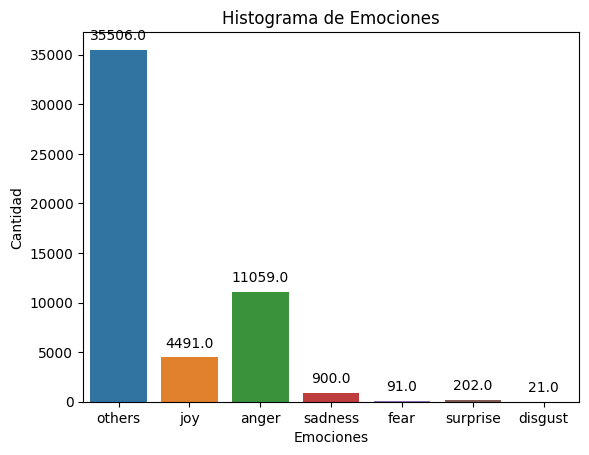

In [ ]:
ax = sns.countplot(x='emotions', data=df_originales)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel("Emociones")
plt.ylabel("Cantidad")
plt.title("Histograma de Emociones")
plt.show()

In [ ]:
# Instancia de TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=800, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings_rtas)

In [ ]:
# Asignamos los embeddings al dataset de respuestas
df_rtas["x"] = tsne_embeddings[:,0]
df_rtas["y"] = tsne_embeddings[:,1]

In [ ]:
# Visualización con dimensionalidad reducida
fig = px.scatter(data_frame=df_rtas, x="x", y="y", hover_name="full_text", hover_data=["emotions"], color="emotions")
fig.update_layout(width=1000, height=1000)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Histograma de barras de los sentimientos detectados para visualizar la distribución.

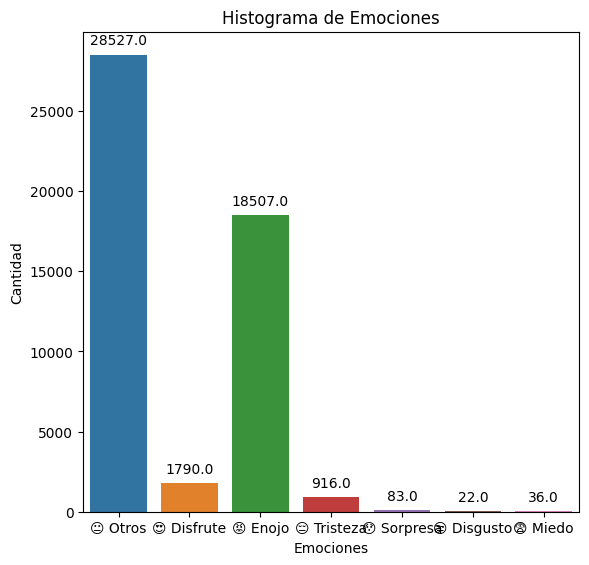

In [ ]:
# Reemplazamos los valores del campo emotions por los nuevos valores
df_rtas['emotions_es'] = df_rtas['emotions'].replace(EMOTIONS_ES)


ax = sns.countplot(x='emotions_es', data=df_rtas)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel("Emociones")
plt.ylabel("Cantidad")
plt.title("Histograma de Emociones")
plt.subplots_adjust(top=1.1, bottom=0.1)
plt.show()

## Word cloud

Creación de la nube de palabras.

La lista de stopwords se actualiza para evitar los nombres de las cuentas `lista_medios`.

La variable `emotion` almacena una cadena de texto. La cadena de texto corresponde a la emoción identificada desde PySentimiento, y toma la posición de la lista `["anger","sadness","surprise","disgust","joy","fear","others"][6]` Donde `6` corresponde a la posición de la lista.



<ipython-input-83-f1390c76c4ea>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('[^\w\s]','').str.lower()


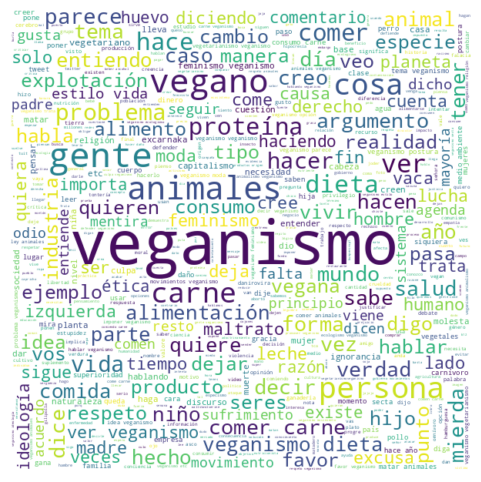

In [ ]:
emotion = ["anger","sadness","surprise","disgust","joy","fear","others"][0]

# Crear una cadena de texto con todos los tweets sin las stopwords en español
df_full_text = df_rtas[df_rtas["emotions"] == emotion][["full_text","emotions"]]


stopwords_es = set(stop_words)
stopwords_es.update(["http", "https"])
#stopwords_es.update(lista_medios)

generate_wordcloud(df=df_full_text, column="full_text", stopwords=stopwords_es)

In [ ]:
def get_wordcloud(df):
    # Crear una cadena de texto con todos los tweets sin las stopwords en español
    df_full_text = df[["full_text"]]
    generate_wordcloud(df=df_full_text, column="full_text", stopwords=stopwords_es)

def wordcloud_per_emotion(emotion, df):
    # Crear una cadena de texto con todos los tweets sin las stopwords en español
    df_full_text = df[df["emotions"] == emotion][["full_text","emotions"]]
    generate_wordcloud(df=df_full_text, column="full_text", stopwords=stopwords_es)

<ipython-input-83-f1390c76c4ea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna('')
<ipython-input-83-f1390c76c4ea>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: str(x))
<ipython-input-83-f1390c76c4ea>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

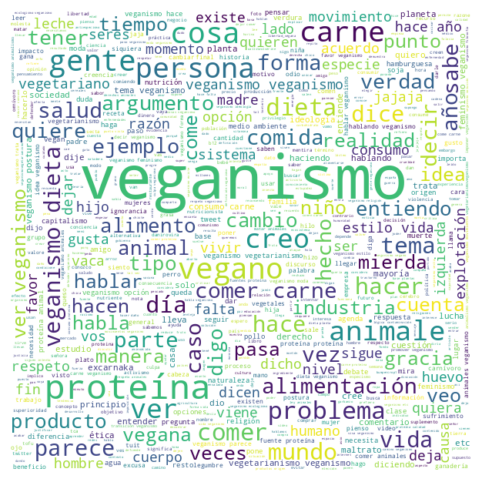

In [ ]:
get_wordcloud(df=df_rtas)

<ipython-input-83-f1390c76c4ea>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('[^\w\s]','').str.lower()


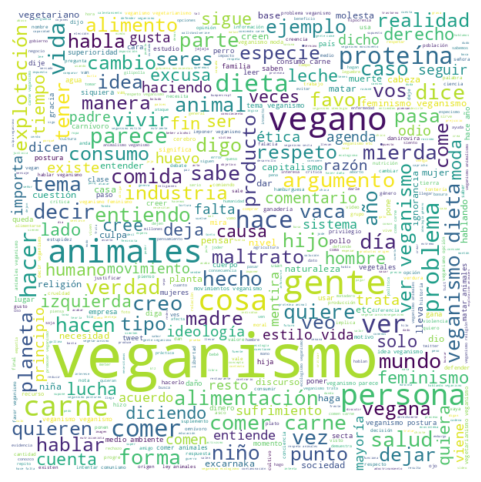

In [ ]:
emotion = ["anger","sadness","surprise","disgust","joy","fear","others"][0]
wordcloud_per_emotion(emotion, df=df_rtas)

<ipython-input-83-f1390c76c4ea>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('[^\w\s]','').str.lower()


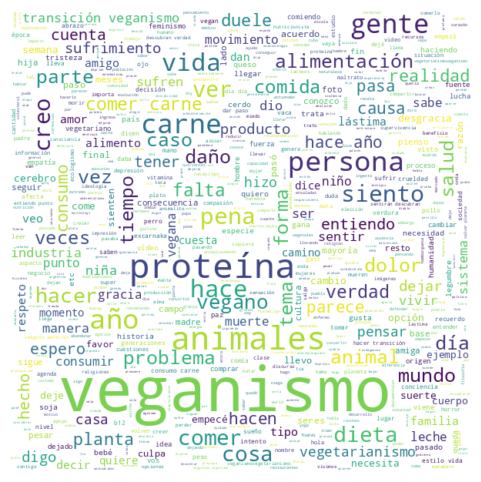

In [ ]:
emotion = ["anger","sadness","surprise","disgust","joy","fear","others"][1]
wordcloud_per_emotion(emotion, df=df_rtas)

<ipython-input-83-f1390c76c4ea>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('[^\w\s]','').str.lower()


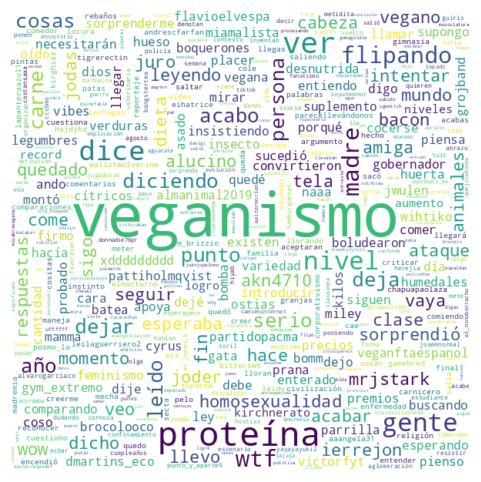

In [ ]:
emotion = ["anger","sadness","surprise","disgust","joy","fear","others"][2]
wordcloud_per_emotion(emotion, df=df_rtas)

<ipython-input-83-f1390c76c4ea>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('[^\w\s]','').str.lower()


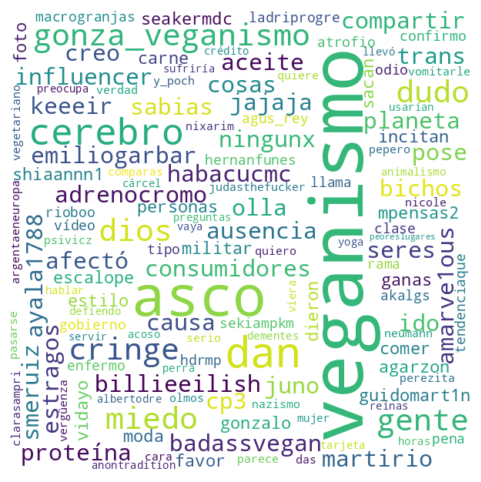

In [ ]:
emotion = ["anger","sadness","surprise","disgust","joy","fear","others"][3]
wordcloud_per_emotion(emotion, df=df_rtas)

<ipython-input-83-f1390c76c4ea>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('[^\w\s]','').str.lower()


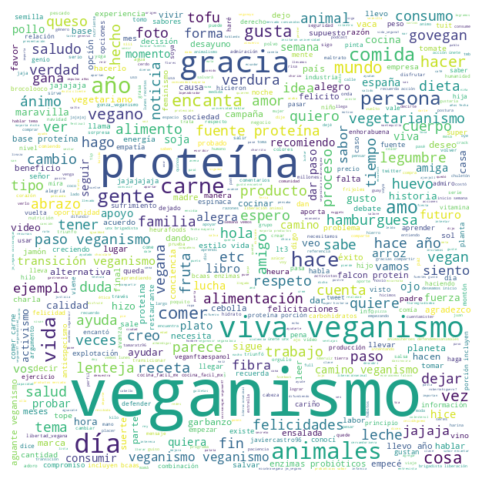

In [ ]:
emotion = ["anger","sadness","surprise","disgust","joy","fear","others"][4]
wordcloud_per_emotion(emotion, df=df_rtas)

<ipython-input-83-f1390c76c4ea>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('[^\w\s]','').str.lower()


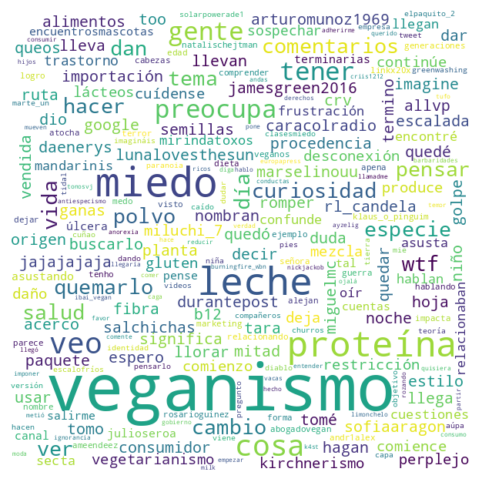

In [ ]:
emotion = ["anger","sadness","surprise","disgust","joy","fear","others"][5]
wordcloud_per_emotion(emotion, df=df_rtas)

<ipython-input-83-f1390c76c4ea>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('[^\w\s]','').str.lower()


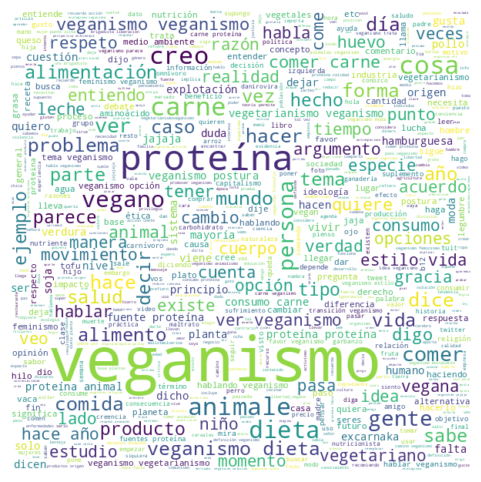

In [ ]:
emotion = ["anger","sadness","surprise","disgust","joy","fear","others"][6]
wordcloud_per_emotion(emotion, df=df_rtas)

## Clustering de respuestas

Modelo: KMeans

In [ ]:
def get_topwords(data, cant_palabras=10):
    cluster_groups = data.groupby('cluster')
    topwords_by_cluster = {}

    for cluster, tweets in cluster_groups:
        words_frequency = {}
        for tweet in tweets['full_text_clean']:
            tokens = nltk.word_tokenize(tweet)
            filtered_words = [word for word in tokens]
            for word in filtered_words:
                if word in words_frequency:
                    words_frequency[word] += 1
                else:
                    words_frequency[word] = 1
        topwords_by_cluster[cluster] = words_frequency

    for cluster, words_frequency in topwords_by_cluster.items():
        print(f"\tTop words for cluster {cluster} :")
        sorted_words = sorted(words_frequency.items(), key=lambda x: x[1], reverse=True)[:cant_palabras+1]
        for word, frequency in sorted_words:
            print(f"{word} ({frequency} times)")

def get_cluster(data, embeddings_data, n_clusters=10):
    # TODO: Meto 10...podríamos ver qué cantidad de clusters fittea mejor
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    kmeans.fit(embeddings_data)

    data["cluster"] = kmeans.labels_

In [ ]:
get_cluster(data=df_rtas, embeddings_data=embeddings_rtas, n_clusters=5)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
print(df_rtas.shape)
df_rtas[["full_text_clean", "cluster"]].groupby(by=["cluster"]).count()

(49881, 14)


full_text_clean
cluster                 
0                  14131
1                   5545
2                   9734
3                   5722
4                  14749

## Topwords

In [ ]:
get_topwords(df_rtas, cant_palabras=20)

	Top words for cluster 0 :
@ (15352 times)
veganismo (14605 times)
animales (4276 times)
carne (2683 times)
animal (2135 times)
dieta (1915 times)
vegano (1552 times)
vida (1347 times)
veganos (1302 times)
gente (1197 times)
vegana (1020 times)
consumo (907 times)
ética (906 times)
personas (797 times)
productos (769 times)
explotación (745 times)
alimentación (739 times)
salud (714 times)
solo (712 times)
humanos (622 times)
vegetarianismo (594 times)
	Top words for cluster 1 :
@ (6323 times)
proteína (6321 times)
vegetal (5395 times)
animal (1254 times)
carne (896 times)
leche (328 times)
proteínas (315 times)
dieta (296 times)
legumbres (292 times)
fuente (291 times)
consumo (287 times)
soja (268 times)
veganismo (262 times)
mejor (239 times)
calidad (233 times)
aminoácidos (228 times)
vegetales (224 times)
alimentos (211 times)
origen (205 times)
lentejas (193 times)
animales (192 times)
	Top words for cluster 2 :
veganismo (9511 times)
@ (9141 times)
carne (135 times)
veganos (116

In [ ]:
df_rtas.shape

(49881, 14)

In [ ]:
frecuencias_por_cluster = frequency_dict_by_cluster_no_handles(df_rtas, 'full_text_clean', 'cluster')
for cluster in frecuencias_por_cluster:
    print(f"Cluster {cluster}")
    top_words = sorted(frecuencias_por_cluster[cluster], key=frecuencias_por_cluster[cluster].get, reverse=True)[:100]
    print(top_words)

Cluster 1
['proteína', 'vegetal', 'animal', 'carne', 'leche', 'proteínas', 'dieta', 'legumbres', 'fuente', 'consumo', 'soja', 'veganismo', 'mejor', 'calidad', 'aminoácidos', 'vegetales', 'alimentos', 'origen', 'lentejas', 'animales', 'fuentes', 'buena', 'soya', 'verduras', 'cantidad', 'arroz', 'alimentación', 'vegano', 'base', 'pollo', 'solo', 'veganos', 'día', 'tofu', 'agua', 'proteina', 'cuerpo', 'comida', 'años', 'vez', 'productos', 'vitaminas', 'cereales', 'carbohidratos', 'huevo', 'cosas', 'valor', 'veces', 'mayor', 'esenciales', 'salud', 'garbanzos', 'vegana', 'pescado', 'ejemplo', 'igual', 'hecho', 'saludable', 'alto', 'problema', 'huevos', 'gente', 'frijoles', 'semillas', 'mundo', 'sabor', 'tipo', 'frutos', 'nutrientes', 'queso', 'completa', 'alimento', 'granos', 'secos', 'producción', 'carnes', 'grasa', 'hierro', 'frutas', 'caso', 'avena', 'parte', 'tema', 'humano', 'grasas', 'bueno', 'vitamina', 'gran', 'plato', 'B12', 'forma', 'biológico', 'vegetariana', 'azúcar', 'rica', 'b

In [ ]:
emotion_distribution = df_rtas.groupby(['cluster', 'emotions']).size().reset_index(name='count')
print(emotion_distribution)

    cluster  emotions  count
0         0     anger   7047
1         0      fear      1
2         0       joy    101
3         0    others   6748
4         0   sadness    233
5         0  surprise      1
6         1     anger    712
7         1   disgust      1
8         1      fear      5
9         1       joy    326
10        1    others   4411
11        1   sadness     82
12        1  surprise      8
13        2     anger   1324
14        2   disgust      9
15        2      fear     10
16        2       joy    550
17        2    others   7657
18        2   sadness    153
19        2  surprise     31
20        3     anger   2774
21        3   disgust      6
22        3      fear      3
23        3       joy    227
24        3    others   2608
25        3   sadness     98
26        3  surprise      6
27        4     anger   6650
28        4   disgust      6
29        4      fear     17
30        4       joy    586
31        4    others   7103
32        4   sadness    350
33        4  s

In [ ]:
cluster_counts = df_rtas['cluster'].value_counts()
total_tweets = len(df_rtas)

for cluster, count in cluster_counts.items():
    cluster_percentage = (count / total_tweets) * 100
    print(f"Cluster {cluster} contains {count} tweets, which is {cluster_percentage:.2f}% of the dataset")

Cluster 4 contains 14749 tweets, which is 29.57% of the dataset
Cluster 0 contains 14131 tweets, which is 28.33% of the dataset
Cluster 2 contains 9734 tweets, which is 19.51% of the dataset
Cluster 3 contains 5722 tweets, which is 11.47% of the dataset
Cluster 1 contains 5545 tweets, which is 11.12% of the dataset


## Distribución por cluster

In [ ]:
fig = px.scatter(data_frame=df_rtas, x="x", y="y",
                 hover_name="full_text_clean",
                 hover_data=["emotions"],
                 color="cluster")

# Change fig size

fig.update_layout(
    width=1000,
    height=1000
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_rtas.head()

created_at             user               id_str  \
0  {'$date': '2023-03-22T17:23:35Z'}  quierovivirsano  1638592270705238016   
1  {'$date': '2023-04-16T17:46:20Z'}      guadaluuz13  1647657690993238016   
2  {'$date': '2022-11-29T01:17:11Z'}          SmeRuiz  1597399240933666816   
3  {'$date': '2020-01-15T15:42:53Z'}          SmeRuiz  1217472227068780544   
4  {'$date': '2019-12-27T04:53:08Z'}          SmeRuiz  1210423345063301120   

                                           full_text  \
0  👉 Evita los alimentos azucarados y procesados:...   
1  @NatyEmme @LBrillantina @JoseePoy No faltan pr...   
2  @danieeel090 Hazte un wrap de quinoa con humus...   
3  @AerithBloodmoon @Blind_dumb_deaf Yo me referí...   
4  @tlapota No. Las leguminosas son fuente de pro...   

  in_reply_to_status_id_str in_reply_to_user_id_str in_reply_to_screen_name  \
0       1638592269497376786              1960919934         quierovivirsano   
1       1647568806208851972               361670874                NatyEmme   
2       1597240042862542854     1056654843455123456         tutiochavorruco   
3       1217467309582962690                39523618         AerithBloodmoon   
4       1210417045856301061              1385597652                 tlapota   

  keyword_scrap_tweetpy emotions  \
0      proteína vegetal   others   
1      proteína vegetal   others   
2      proteína vegetal   others   
3      proteína vegetal   others   
4      proteína vegetal   others   

                                     full_text_clean          x          y  \
0  alimentos azucarados procesados efectos negati...  55.868984   5.382954   
1  @LBrillantina @JoseePoy proteínas legumbres ha...  55.846104  -1.357158   
2  @danieeel090 wrap quinoa humus aguacate proteí...  72.208183   8.724448   
3                                   proteína vegetal  69.720177   1.262180   
4  leguminosas fuente proteína vegetal suficiente...  63.992554  11.076348   

  emotions_es  cluster  
0     😐 Otros        1  
1     😐 Otros        1  
2     😐 Otros        1  
3     😐 Otros        1  
4     😐 Otros        1

# Paso 5: Guardar los resultados en un archivo

El archivo contiene los resultados obtenidos luego del procesamiento. Los campos agregados son:

- emotion
- cluster
- x
- y

In [ ]:
# Almacenar resultados en archivo JSON
df_rtas.to_json("proteinasvegetales_respuestas_por_cluster.json", orient = 'records', force_ascii=False, indent=4)

In [ ]:
# Revisión a detalle de los comentarios.
# Permite hacer una análisis en un archivo Excel
campos = ["cluster","emotions","full_text","full_text_clean",
          "user", #"screen_name",
          "in_reply_to_screen_name",
          "in_reply_to_status_id_str","x","y"]
df_rtas[campos].to_excel("proteinasvegetales_respuestas_por_cluster.xlsx", index=False)

# Paso 6: Análisis Estadístico

In [ ]:
class DatosEstadisticos():
    def __init__(self):
        pass

    def tweets_per_year(self, df, field):
        df_by_year = df
        df_by_year["year"] = df_by_year[field].apply(lambda x:
                                                      datetime.datetime.strptime(x["$date"], "%Y-%m-%dT%H:%M:%S%z")
                                                      .date()
                                                      .strftime('%Y'))
        df_by_year = df_by_year.groupby(["year"]).count()[[field]]
        df_by_year.rename(columns={field: "tweets"}, inplace=True)
        return df_by_year

    def distribucion_per_emotion(self, df, field):
        df_per_emotion = df
        df_per_emotion = df_per_emotion.groupby([field]).count()[["created_at"]]
        df_per_emotion.rename(columns={"created_at": "Cantidad"}, inplace=True)
        df_per_emotion.sort_values(by=["Cantidad"], ascending=False, inplace=True)
        return df_per_emotion

    def savefile(self, file_name="", dataframes=[], sheets_names=[]):
        writer = pd.ExcelWriter(file_name, engine='xlsxwriter')
        for index, dataframe in enumerate(dataframes):
            dataframe.to_excel(writer, sheet_name=sheets_names[index])
        writer.save()


# Creación del DataFrame
FILE_NAME = "/content/drive/MyDrive/Colab Notebooks/Datasets/robertuito/output/collection_proteinavegetal_es.json"
FILE_NAME_RESULTS = "/content/drive/MyDrive/Colab Notebooks/Datasets/robertuito/output/proteinasvegetales_respuestas_por_cluster.json"
FILE_NAME_DATOSESTADISTICOS = "datos-estadisticos.xlsx"

df_todos = pd.read_json(FILE_NAME, dtype=dtypes_json_file)
df_results = pd.read_json(FILE_NAME_RESULTS, dtype=dtypes_json_file)

# Reemplazamos los valores del campo emotions por los nuevos valores
df_results['emotions_es'] = df_results["emotions"].replace(EMOTIONS_ES)

In [ ]:
datos_estadisticos = DatosEstadisticos()
df_by_year = datos_estadisticos.tweets_per_year(df_todos.copy(), "date") # created_at
df_per_emotion = datos_estadisticos.distribucion_per_emotion(df_results.copy(), "emotions_es")

datos_estadisticos.savefile(FILE_NAME_DATOSESTADISTICOS,
                            dataframes=[df_by_year, df_per_emotion],
                            sheets_names=["year", "emotion-replies"])

In [ ]:
count_tweets_total = df_todos.shape[0]
count_tweets_replies = df_results.shape[0]
count_tweets_originales = count_tweets_total - count_tweets_replies

In [ ]:
cuentas_analizadas = list(df_todos.groupby("user").sum().index)

In [ ]:
print(f"Cantidad total de tweets (tweets y replies/comentarios): {count_tweets_total}")
print(f"Cantidad de tweets: {count_tweets_originales}")
print(f"Cantidad de replies/comentarios: {count_tweets_replies}")
print(f"Cuentas analizadas: {cuentas_analizadas}")

Cantidad total de tweets (tweets y replies/comentarios): 102151
Cantidad de tweets: 52270
Cantidad de replies/comentarios: 49881
Cuentas analizadas: ['0000000000012c', '001989ts', '0096_licencia', '0098abril', '00Greenwich', '00O0O0O0OO187', '00ppao', '00teit', '00viccc', '01Law_88', '01_00_00_11', '01dianaperez', '01roddy', '026soff', '03SMarin', '04josehernand1', '0513VENUS', '0555Ale', '05Torz', '0604_sandra', '061xmu', '06oct06', '071044fidaa', '0800Mari', '0800eng', '0800escarlata', '0800gmg', '0800luiz', '0800sangria', '08Cristianft', '09022j', '09MACvida', '09ValentinaC', '0Cocina', '0Kilgor', '0Lalali2', '0Milanesas28', '0NIONGIRL', '0P4in', '0QGc7yVBO9D2Pak', '0Roulette', '0Symfonia2', '0Ultranietzsche', '0Uri3eli', '0X1MVSK', '0_Lethe_0', '0___Abraxas___0', '0_fedetorres', '0analucia1', '0broni', '0bsdn', '0bsesionaria', '0ctubr3r0j02012', '0fefocosta0', '0hmyfuck', '0luisviola', '0nreivni', '0o090909', '0oneinmany', '0pinandoand0', '0takuindigena', '0utroHome', '0whitemonste

# Paso 7: Resultados y conclusiones

## Resultados

Las respuestas de los tweets sobre proteínas vegetales en españaol se ha agrupado en grupos para conocer mejor la opinión de las personas respecto a este tema.


Cluster 0:
- Consideran el veganismo como una postura ética.
- Defienden y dan su opinión sobre el veganismo.
- Consideran que es saludable consumir alimentos veganos.
- Están en contra del maltrato y explotación animal.

Cluster 1:
- Comentan sobre lo deliciosas y saludables que son las hamburguesas vegetarianas y veganas.
- La importancia de la soja en la elaboración de las hamburguesas.
- Ofrecen recomendaciones de alimentos que ofrecen proteínas vegetales.
- Comentan sobre alimentación.
- Comparan la ausencia de aminoácidos en proteínas vegetales.

Cluster 2:
- Comentarios sarcásticos sobre el veganismo.
- Comentarios en contra del veganismo por la falta de proteínas para la alimentación.

Cluster 3:
- Personas totalmente en contra del veganismo.
- Consideran el veganismo y vegetarianismo como adoctrinamiento.
- Consideran perjudicial el veganismo para la salud.
- Comentarios ofensivos y de odio acerca del veganismo.

Cluster 4:
- Personas que comentan sobre los problemas de salud que causa el veganismo (en mujeres gestantes, problemas motrices).
- Comentan que sólo las personas con una buena posición económica pueden ser veganos.
- Comentarios sarcásticos sobre el veganismo y vegetarianismo.
- Consideran que hay personas que son veganas sólo por moda.
